<a href="https://colab.research.google.com/github/ethan-feldman/mandarin-tone-classifier/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount and load data
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
dir_path = "/content/drive/MyDrive/tone_perfect"
!mkdir -p /content/tones
!cp /content/drive/MyDrive/tone_perfect/* /content/tones/

In [5]:
# Create dataset class, iterate once and verify correctness
from pathlib import Path
import torch
import torchaudio
from torch.utils.data import Dataset
import pandas as pd

class ChineseToneDataset(Dataset):
  def __init__(self, dir_path, transformation,
               target_sample_rate, device):
    self.dir_path = dir_path
    list_of_mp3s_iter = Path(dir_path).glob('*.mp3')
    self.list_of_mp3s = list(list_of_mp3s_iter)
    self.device = device
    self.transformation = transformation.to(self.device)
    self.target_sample_rate = target_sample_rate
    self.max_second_dim = self._calculate_max_second_dim()

  def _calculate_max_second_dim(self):
    max_second_dim = 0
    for mp3_path in self.list_of_mp3s:
      signal, sr = torchaudio.load(mp3_path)
      max_second_dim = max(max_second_dim, signal.shape[-1])
    return max_second_dim

  def __len__(self):
    return len(self.list_of_mp3s)

  def _mix_down_if_necessary(self, signal):
    if signal.shape[0] > 1:
      signal = torch.mean(signal, dim=0, keepdim=True)
    return signal

  def _resample_if_necessary(self, signal, sr):
    if sr != self.target_sample_rate:
      resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
      signal = resampler(signal)
    return signal

  def _right_pad_if_necessary(self, signal):
    length_signal = signal.shape[1]
    if length_signal < self.max_second_dim:
      num_missing_samples = self.max_second_dim - length_signal
      last_dim_padding = (0, num_missing_samples)
      signal = torch.nn.functional.pad(signal, last_dim_padding)
    return signal

  def __getitem__(self, index):
    mp3_path = self.list_of_mp3s[index]

    # parse out tone
    path_stem = mp3_path.stem
    components = path_stem.split("_")
    pinyin_plus_tone = components[0]

    tone = int(pinyin_plus_tone[-1]) - 1 # 0 index tones
    assert 0 <= tone <= 3

    # process mp3 signal
    signal, sr = torchaudio.load(mp3_path)
    # signal -> (num_channels, samples) ex: (2, 16000) -> (1, 16000)

    signal = self._resample_if_necessary(signal, sr)
    signal = self._mix_down_if_necessary(signal)
    signal = self._right_pad_if_necessary(signal)
    signal = self.transformation(signal)
    return signal, tone

Using cpu


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

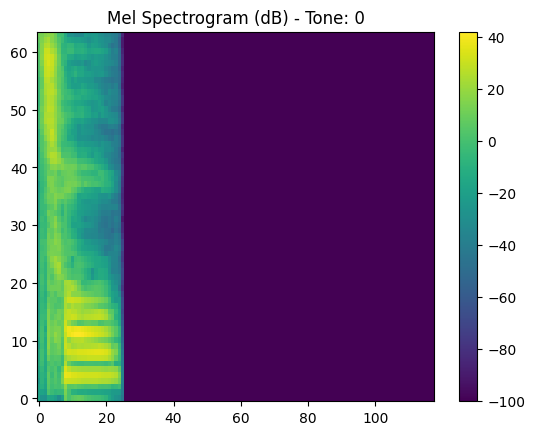

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")


SAMPLE_RATE = 22050
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

ctd = ChineseToneDataset("/content/tones", mel_spectrogram, SAMPLE_RATE, device)

import matplotlib.pyplot as plt

signal, label = ctd[1000]

import torchaudio

db_transform = torchaudio.transforms.AmplitudeToDB()
db_signal = db_transform(signal)

plt.imshow(db_signal[0].numpy(), origin="lower", aspect="auto")
plt.title(f"Mel Spectrogram (dB) - Tone: {label}")
plt.colorbar()
plt.show()

In [8]:
import torch
import torchaudio
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Hyper parameters
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-3
SAMPLE_RATE = 22050
device = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 4

In [9]:
def train_one_epoch(model, data_loader, loss_fn, optimiser, device):
    """
    One pass over the training set.
    Returns: avg_train_loss (float), train_accuracy (float)
    """
    model.train()
    loss_sum, n_total, n_correct = 0.0, 0, 0

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        logits = model(inputs)               # (B, NUM_CLASSES)
        loss   = loss_fn(logits, targets)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        # metrics
        batch_size = targets.size(0)
        loss_sum  += loss.item() * batch_size
        n_total   += batch_size
        n_correct += (logits.argmax(1) == targets).sum().item()

    return loss_sum / n_total, n_correct / n_total


@torch.no_grad()
def eval_one_epoch(model, data_loader, loss_fn, device, compute_cm=False, num_classes=NUM_CLASSES):
    """
    Evaluation on validation set (no gradients).
    If compute_cm=True, also returns a confusion matrix.
    Returns: avg_val_loss (float), val_accuracy (float), (optional) cm (Tensor[k,k])
    """
    model.eval()
    loss_sum, n_total, n_correct = 0.0, 0, 0
    cm = torch.zeros(num_classes, num_classes, dtype=torch.long, device="cpu") if compute_cm else None

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        loss   = loss_fn(logits, targets)

        # metrics
        batch_size = targets.size(0)
        loss_sum  += loss.item() * batch_size
        n_total   += batch_size
        preds      = logits.argmax(1)
        n_correct += (preds == targets).sum().item()

        if compute_cm:
            # accumulate confusion matrix on CPU
            t = targets.detach().to("cpu").to(torch.long).view(-1)
            p = preds.detach().to("cpu").to(torch.long).view(-1)
            k = num_classes
            idx = (t * k + p)
            cm += torch.bincount(idx, minlength=k*k).reshape(k, k)

    avg_loss = loss_sum / n_total
    acc      = n_correct / n_total
    return (avg_loss, acc, cm) if compute_cm else (avg_loss, acc)


def plot_loss_curves(train_losses, val_losses, title="Loss vs. Epoch"):
    plt.figure()
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses,   label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()


def plot_confusion_matrix(cm, class_names=None, title="Confusion Matrix (Validation)"):
    """
    cm: 2D numpy array or tensor [k,k]
    """
    cm = cm.cpu().numpy() if isinstance(cm, torch.Tensor) else cm
    fig, ax = plt.subplots()
    im = ax.imshow(cm, origin="upper")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    k = cm.shape[0]
    ax.set_xticks(range(k)); ax.set_yticks(range(k))
    if class_names:
        ax.set_xticklabels(class_names)
        ax.set_yticklabels(class_names)
    ax.set_title(title)
    for i in range(k):
        for j in range(k):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center")
    plt.colorbar(im)
    plt.show()

In [12]:
from torch.utils.data import Dataset
from torch import nn
from torchsummary import summary

# Feed Forward Net
class FeedForwardNet(nn.Module):
  def __init__(self, example_batch, num_classes=NUM_CLASSES):
    super().__init__()
    self.flatten = nn.Flatten()
    num_features = self.flatten(example_batch).shape[1]  # infer from data
    self.mlp = nn.Sequential(
        nn.Linear(num_features, 256), # # of input features, # of output features
        nn.ReLU(), # activation function
        nn.Linear(256, NUM_CLASSES) # last layer
    )
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x): # forward pass / specify dataflow
    x = self.flatten(x)
    logits = self.mlp(x)
    return logits

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Epoch 01 | train_loss=31.2867  train_acc=0.804 | val_loss=1.8365  val_acc=0.890
Epoch 02 | train_loss=1.1538  train_acc=0.914 | val_loss=1.0729  val_acc=0.919
Epoch 03 | train_loss=0.6025  train_acc=0.942 | val_loss=1.5356  val_acc=0.921
Epoch 04 | train_loss=0.4959  train_acc=0.956 | val_loss=1.2181  val_acc=0.933
Epoch 05 | train_loss=0.6710  train_acc=0.959 | val_loss=1.1782  val_acc=0.932
Epoch 06 | train_loss=0.3449  train_acc=0.966 | val_loss=1.2557  val_acc=0.943
Epoch 07 | train_loss=0.5348  train_acc=0.969 | val_loss=1.8606  val_acc=0.934
Epoch 08 | train_loss=0.4345  train_acc=0.973 | val_loss=0.8727  val_acc=0.956
Epoch 09 | train_loss=0.4068  train_acc=0.975 | val_loss=0.9144  val_acc=0.948
Epoch 10 | train_loss=0.5652  train_acc=0.970 | val_loss=1.4516  val_acc=0.946


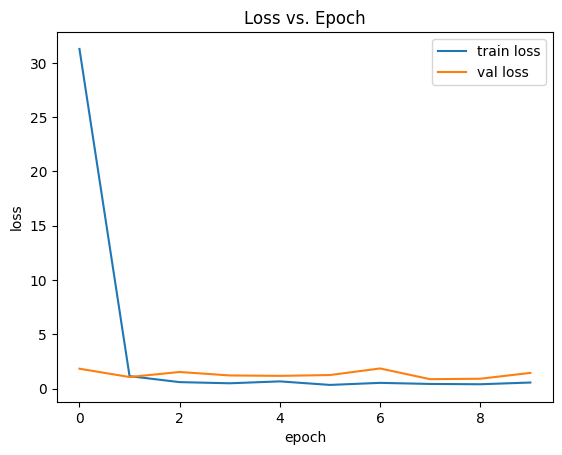

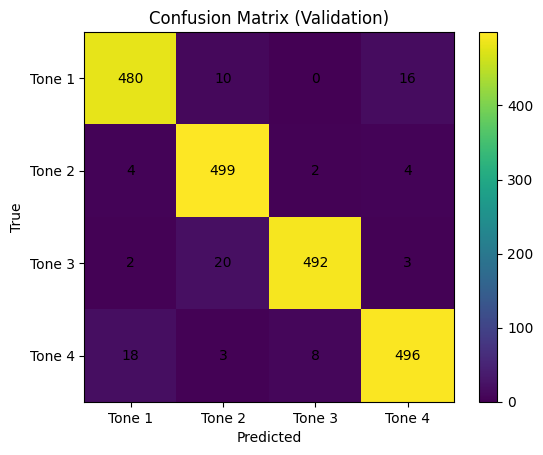

In [13]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64
)

# You already have this class in your project
ctd = ChineseToneDataset("/content/tones", mel_spectrogram, SAMPLE_RATE, device)

# Train/val split (reproducible)
n_total = len(ctd)
n_train = int(0.8 * n_total)
ctd_train, ctd_val = random_split(
    ctd, [n_train, n_total - n_train],
    generator=torch.Generator().manual_seed(0)
)

train_loader = DataLoader(ctd_train, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(ctd_val,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ---- Build model (infer input dim from a real batch) ----
example_batch, _ = next(iter(train_loader))                 # (B,H,W) typically
example_batch = example_batch.to(device)
model = FeedForwardNet(example_batch, num_classes=NUM_CLASSES).to(device)

# ---- Loss & Optimizer ----
loss_fn  = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ---- Train loop with history + best checkpoint (by val loss) ----
train_losses, val_losses = [], []
best_val = float("inf")

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, loss_fn, optimiser, device)
    va_loss, va_acc = eval_one_epoch(model, val_loader,   loss_fn, device, compute_cm=False)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)

    if va_loss < best_val:
        best_val = va_loss
        torch.save(model.state_dict(), "feedforwardnet_best.pth")

    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f}  train_acc={tr_acc:.3f} "
          f"| val_loss={va_loss:.4f}  val_acc={va_acc:.3f}")

# Optional: save last
torch.save(model.state_dict(), "feedforwardnet_last.pth")

# ---- Curves ----
plot_loss_curves(train_losses, val_losses)

# ---- Confusion matrix on validation set using BEST weights ----
best_model = FeedForwardNet(example_batch, num_classes=NUM_CLASSES).to(device)
best_model.load_state_dict(torch.load("feedforwardnet_best.pth", map_location=device))

_, _, cm = eval_one_epoch(best_model, val_loader, loss_fn, device, compute_cm=True, num_classes=NUM_CLASSES)

# If your class ids are 0..3, you can label them like this:
tone_names = ["Tone 1", "Tone 2", "Tone 3", "Tone 4"]
plot_confusion_matrix(cm, class_names=tone_names)

In [15]:
def train_one_epoch(model, loader, loss_fn, optim, device, preprocess=lambda x: x):
    """Train for one epoch. Returns avg loss, accuracy."""
    model.train()
    loss_sum, n_total, n_correct = 0.0, 0, 0
    for x, y in loader:
        x = preprocess(x).to(device); y = y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        bs = y.size(0)
        loss_sum  += loss.item() * bs
        n_total   += bs
        n_correct += (logits.argmax(1) == y).sum().item()
    return loss_sum / n_total, n_correct / n_total

@torch.no_grad()
def eval_one_epoch(model, loader, loss_fn, device, preprocess=lambda x: x,
                   compute_cm=False, num_classes=NUM_CLASSES):
    """Validate for one epoch. Optionally return confusion matrix."""
    model.eval()
    loss_sum, n_total, n_correct = 0.0, 0, 0
    cm = torch.zeros(num_classes, num_classes, dtype=torch.long) if compute_cm else None

    for x, y in loader:
        x = preprocess(x).to(device); y = y.to(device)
        logits = model(x)
        loss   = loss_fn(logits, y)
        preds  = logits.argmax(1)

        bs = y.size(0)
        loss_sum  += loss.item() * bs
        n_total   += bs
        n_correct += (preds == y).sum().item()

        if compute_cm:
            k = num_classes
            idx = (y.cpu().long() * k + preds.cpu().long())
            cm += torch.bincount(idx, minlength=k*k).reshape(k, k)

    return (loss_sum / n_total, n_correct / n_total, cm) if compute_cm else (loss_sum / n_total, n_correct / n_total)

def train_model(model, train_loader, val_loader, epochs, lr, device, name, preprocess):
    """End-to-end train/val with best-by-val-loss checkpoint; return history + best path."""
    loss_fn = nn.CrossEntropyLoss()
    optim   = torch.optim.Adam(model.parameters(), lr=lr)

    hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val, best_path = float("inf"), f"{name}_best.pth"

    for ep in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, loss_fn, optim, device, preprocess)
        va_loss, va_acc = eval_one_epoch(model,  val_loader,   loss_fn, device, preprocess)
        hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(va_loss);   hist["val_acc"].append(va_acc)

        if va_loss < best_val:
            best_val = va_loss
            torch.save(model.state_dict(), best_path)

        print(f"[{name}] epoch {ep:02d} | train_loss {tr_loss:.4f} acc {tr_acc:.3f} | val_loss {va_loss:.4f} acc {va_acc:.3f}")
    return hist, best_path

def plot_loss_acc_compare(hist_a, hist_b, label_a, label_b):
    """Overlay loss/acc curves for two models."""
    # Loss
    plt.figure()
    plt.plot(hist_a["train_loss"], label=f"{label_a} train")
    plt.plot(hist_a["val_loss"],   label=f"{label_a} val")
    plt.plot(hist_b["train_loss"], label=f"{label_b} train", linestyle="--")
    plt.plot(hist_b["val_loss"],   label=f"{label_b} val",   linestyle="--")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss vs Epoch"); plt.legend(); plt.show()
    # Acc
    plt.figure()
    plt.plot(hist_a["train_acc"], label=f"{label_a} train")
    plt.plot(hist_a["val_acc"],   label=f"{label_a} val")
    plt.plot(hist_b["train_acc"], label=f"{label_b} train", linestyle="--")
    plt.plot(hist_b["val_acc"],   label=f"{label_b} val",   linestyle="--")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Accuracy vs Epoch"); plt.legend(); plt.show()

def plot_confusion_matrix(cm, class_names=None, title="Confusion Matrix"):
    """Simple heatmap CM with counts."""
    import numpy as np
    cm = cm.cpu().numpy() if isinstance(cm, torch.Tensor) else np.array(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, origin="upper")
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    k = cm.shape[0]; ax.set_xticks(range(k)); ax.set_yticks(range(k))
    if class_names: ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)
    for i in range(k):
        for j in range(k):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center")
    plt.colorbar(im); plt.show()

def metrics_from_cm(cm):
    """
    cm: (K,K) confusion matrix (rows=true, cols=pred)
    Returns:
      acc         : overall validation accuracy
      avg_recall  : average of per-class recall
      per_recall  : array of per-class recall
    """
    cm = cm.detach().cpu().numpy() if isinstance(cm, torch.Tensor) else np.asarray(cm)
    total = cm.sum()
    acc = (np.trace(cm) / total) if total else 0.0
    per_recall = np.divide(np.diag(cm), cm.sum(axis=1) + 1e-12)  # TP / (TP+FN) per class
    avg_recall = float(per_recall.mean())
    return float(acc), avg_recall, per_recall

def compare_models_by_acc_and_avg_recall(cm_a, cm_b, name_a="CNN", name_b="MLP", class_names=None):
    acc_a, ar_a, pr_a = metrics_from_cm(cm_a)
    acc_b, ar_b, pr_b = metrics_from_cm(cm_b)

    # Text summary
    print(f"{name_a}: accuracy={acc_a:.3f} | avg recall={ar_a:.3f}")
    print(f"{name_b}: accuracy={acc_b:.3f} | avg recall={ar_b:.3f}")

    # Simple decision rule you can change:
    winner = name_a if (acc_a, ar_a) > (acc_b, ar_b) else name_b
    print(f"\nPick: {winner} (by accuracy then avg recall)\n")

    # Plot 1: Overall metrics side-by-side
    labels = ["Accuracy", "Avg Recall"]
    a_vals = [acc_a, ar_a]
    b_vals = [acc_b, ar_b]
    x = np.arange(len(labels))
    width = 0.35

    plt.figure()
    plt.bar(x - width/2, a_vals, width, label=name_a)
    plt.bar(x + width/2, b_vals, width, label=name_b)
    plt.xticks(x, labels)
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("Model Comparison: Accuracy & Average Recall")
    plt.legend()
    plt.show()

    # Plot 2: Per-class recall comparison (optional)
    if class_names is None:
        class_names = [f"Class {i}" for i in range(len(pr_a))]
    x = np.arange(len(pr_a))
    plt.figure()
    plt.plot(x, pr_a, marker="o", label=f"{name_a} per-class recall")
    plt.plot(x, pr_b, marker="o", linestyle="--", label=f"{name_b} per-class recall")
    plt.xticks(x, class_names, rotation=0)
    plt.ylim(0, 1)
    plt.ylabel("Recall (per class)")
    plt.title("Per-class Recall")
    plt.legend()
    plt.show()

    return {
        name_a: {"accuracy": acc_a, "avg_recall": ar_a, "per_class_recall": pr_a},
        name_b: {"accuracy": acc_b, "avg_recall": ar_b, "per_class_recall": pr_b},
        "winner": winner,
    }



In [16]:
# CNN

class CNNNetwork(nn.Module):
  # pass in channels, kernel size, stride, and padding in constructor
  def __init__(self):
    super().__init__()

    # 4 conv blocks / flatten / linear / softmax
    self.conv1 = nn.Sequential(
      nn.Conv2d(
        in_channels=1, # treat as gray-scale images
        out_channels=16, # 16 filters
        kernel_size=3,
        stride=1,
        padding=2 # zeros around the outside of grid
        ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.conv2 = nn.Sequential(
      nn.Conv2d(
        in_channels=16, # equal to output channels of last layer
        out_channels=32,
        kernel_size=3,
        stride=1,
        padding=2
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.conv3 = nn.Sequential(
      nn.Conv2d(
        in_channels=32,
        out_channels=64,
        kernel_size=3,
        stride=1,
        padding=2
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv4 = nn.Sequential(
      nn.Conv2d(
        in_channels=64,
        out_channels=128,
        kernel_size=3,
        stride=1,
        padding=2
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.gap = nn.AdaptiveAvgPool2d((1, 1))  # (B,128,1,1)
    #mlp layer before or after pol
    self.classifier = nn.Linear(128, 4)       # 4 tones


  def forward(self, input_data):
    x = self.conv1(input_data)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.gap(x)                 # (B, 128, 1, 1)
    x = x.view(x.size(0), -1)       # (B, 128)
    logits = self.classifier(x)     # (B, 4)
    return logits


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

[cnn_tone_classifier] epoch 01 | train_loss 4.0366 acc 0.382 | val_loss 1.1097 acc 0.624
[cnn_tone_classifier] epoch 02 | train_loss 0.7425 acc 0.750 | val_loss 0.4398 acc 0.853
[cnn_tone_classifier] epoch 03 | train_loss 0.3340 acc 0.897 | val_loss 0.2429 acc 0.928
[cnn_tone_classifier] epoch 04 | train_loss 0.2294 acc 0.933 | val_loss 0.1739 acc 0.949
[cnn_tone_classifier] epoch 05 | train_loss 0.1465 acc 0.963 | val_loss 0.2518 acc 0.910
[cnn_tone_classifier] epoch 06 | train_loss 0.1245 acc 0.967 | val_loss 0.1022 acc 0.975
[cnn_tone_classifier] epoch 07 | train_loss 0.0933 acc 0.978 | val_loss 0.0696 acc 0.986
[cnn_tone_classifier] epoch 08 | train_loss 0.0729 acc 0.985 | val_loss 0.0744 acc 0.983
[cnn_tone_classifier] epoch 09 | train_loss 0.0870 acc 0.978 | val_loss 0.0491 acc 0.989
[cnn_tone_classifier] epoch 10 | train_loss 0.0434 acc 0.991 | val_loss 0.0410 acc 0.987
[mlp_tone_classifier] epoch 01 | train_loss 28.0400 acc 0.825 | val_loss 3.5755 acc 0.911
[mlp_tone_classifier

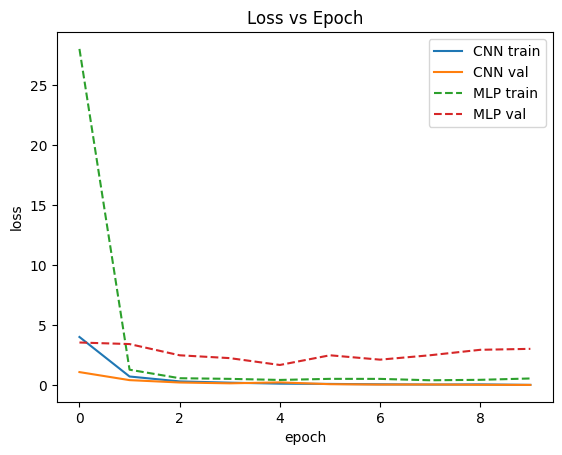

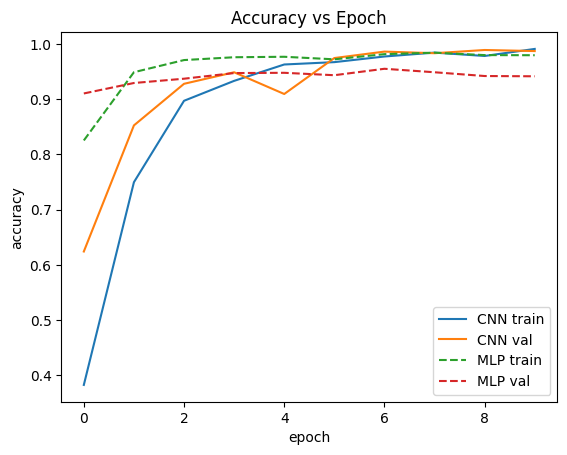

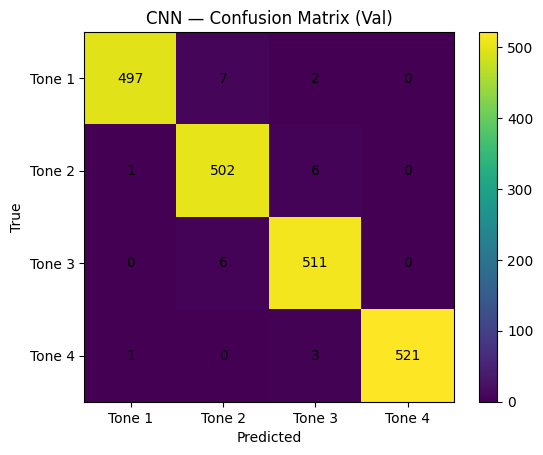

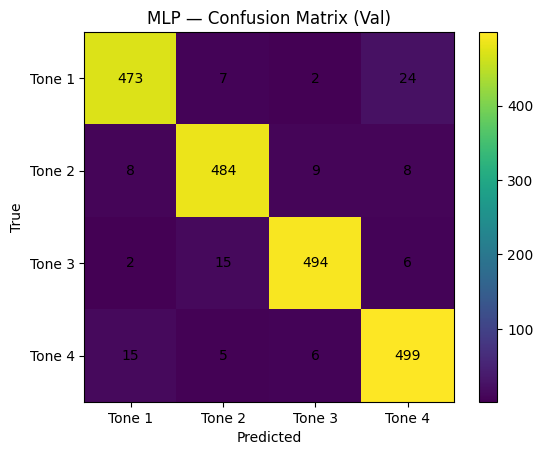

In [17]:
# ---- Mel features & dataset (assumes your ChineseToneDataset yields (mel: HxW, label))
mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64
)
ctd = ChineseToneDataset("/content/tones", mel, SAMPLE_RATE, device)

# train/val split
n_total = len(ctd); n_train = int(0.8 * n_total)
ctd_train, ctd_val = random_split(ctd, [n_train, n_total - n_train],
                                  generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(ctd_train, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(ctd_val,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ---- preprocess hooks
preprocess_cnn = lambda x: x.unsqueeze(1) if x.dim() == 3 else x   # (B,H,W)->(B,1,H,W)
preprocess_mlp = lambda x: x                                       # keep (B,H,W)

# ---- build models (MLP needs an example to infer input dim)
example_batch, _ = next(iter(train_loader))         # (B,H,W)
mlp = FeedForwardNet(example_batch.to(device)).to(device)
cnn = CNNNetwork().to(device)

# ---- train
hist_cnn, best_cnn_path = train_model(cnn, train_loader, val_loader, EPOCHS, LR, device,
                                      name="cnn_tone_classifier", preprocess=preprocess_cnn)
hist_mlp, best_mlp_path = train_model(mlp, train_loader, val_loader, EPOCHS, LR, device,
                                      name="mlp_tone_classifier", preprocess=preprocess_mlp)

# ---- overlay curves (loss + acc)
plot_loss_acc_compare(hist_cnn, hist_mlp, label_a="CNN", label_b="MLP")

# ---- confusion matrices (evaluate best checkpoints)
best_cnn = CNNNetwork().to(device)
best_cnn.load_state_dict(torch.load(best_cnn_path, map_location=device))

best_mlp = FeedForwardNet(example_batch.to(device)).to(device)
best_mlp.load_state_dict(torch.load(best_mlp_path, map_location=device))

_, _, cm_cnn = eval_one_epoch(best_cnn, val_loader, nn.CrossEntropyLoss(), device,
                              preprocess=preprocess_cnn, compute_cm=True)
_, _, cm_mlp = eval_one_epoch(best_mlp, val_loader, nn.CrossEntropyLoss(), device,
                              preprocess=preprocess_mlp, compute_cm=True)

tone_names = ["Tone 1", "Tone 2", "Tone 3", "Tone 4"]
plot_confusion_matrix(cm_cnn, class_names=tone_names, title="CNN — Confusion Matrix (Val)")
plot_confusion_matrix(cm_mlp, class_names=tone_names, title="MLP — Confusion Ma=trix (Val)")
summary = compare_models_by_acc_and_avg_recall(cm_cnn, cm_mlp, name_a="CNN", name_b="MLP", class_names=tone_names)